<a href="https://colab.research.google.com/github/NicobaudinoQ/Aprendizaje-Profundo/blob/Nico/Copia_de_IAP_TP2_G7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TRABAJO PRÁCTICO II (Materia Completa)

#### INTEGRANTES: Baudino Nicolas, Espejo Pablo, Löwenstein Patricia, Tumas Ignacio

####ALTERNATIVA 1: Redes Recurrentes

Dado el dataset que busca detectar si una oración es sarcástica o no. Se pide:

1. Preprocesar los datos de texto teniendo en cuenta como baseline lo que se hizo en esta notebook. Para cargar los datos pueden guiarse de esta notebook introductoria. Tengan cuenta evaluar cual es la longitud máxima de sus sentencias o qué les conviene agregar/sacar para procesar el dataset de sarcasmo.

2. Implementar una red neuronal RNN simple con capas lstm (este será su baseline). Pueden guiarse de la Notebook 8.

3. En una siguiente instancia realizar una busqueda de hiperparametros buscando mejorar el baseline. Traten de centrarse en probar 2, como mucho 3, hiperparametros y ver los cambios en base a esos hiperparametros porque sino las pruebas se hacen infinitas. La idea es que prueben:

  * Diferentes tamaños de épocas,
  * Tamaño de batch,
  * Cantidad de capas lstm,
  * Valor de dropout, etc.

4. Mostrar e Interpretar los resultados usando las curvas de aprendizaje.

5. Opcional: Probar otros tipos de capas como GRU o RNN. Agregar embeddings preentrenados


In [1]:
# Cargar primero el archivo en tu drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive

import gzip
import nltk
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset,DataLoader

from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, trange

In [3]:
nltk.download("stopwords") # Descargamos las stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
seed= 15

dir = "/content/drive/MyDrive/Diplo Datos/Aprendizaje Profundo/sarcasm_dataset.json"

In [6]:
with open(dir, 'r') as file:
    count = 0
    for line in file:
        print(line)
        print('-------')
        count+=1
        if count ==5:
          break

{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0}

-------
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}

-------
{"article_link": "https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697", "headline": "mom starting to fear son's web series closest thing she will have to grandchild", "is_sarcastic": 1}

-------
{"article_link": "https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302", "headline": "boehner just wants wife to listen, not come up with alternative debt-reduction ideas", "is_sarcastic": 1}

-------
{"article_link": "https://www.huffingtonpost.com/entry/j

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
dir = "/content/drive/MyDrive/Diplo Datos/Aprendizaje Profundo/sarcasm_dataset.json"
with open(dir, 'r') as file:
    data = [json.loads(line) for line in file]

In [10]:
# Leemos el dataset
df = pd.DataFrame(data)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [11]:
# Descartamos la columna 'article_link'
df = df.drop(columns=['article_link'])

## 0. Pequeña inspección de los datos

In [12]:
X = df['headline'].values
y = df['is_sarcastic'].values

# Dividir el conjunto de datos en conjuntos de entrenamiento, validación y test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

print(f'Cantidad de datos en train: {X_train.shape[0]}')
print(f'Cantidad de datos en validación: {X_val.shape[0]}')
print(f'Cantidad de datos en test: {X_test.shape[0]}')

Cantidad de datos en train: 18696
Cantidad de datos en validación: 4006
Cantidad de datos en test: 4007


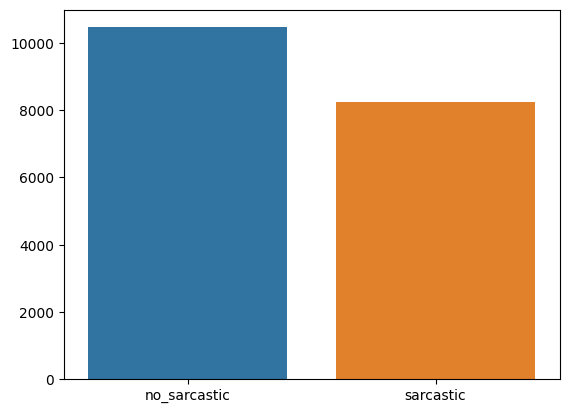

In [13]:
target_dist = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['no_sarcastic','sarcastic']),y=target_dist.values)
plt.show()

## 1. Preprocesar los datos


Nuevamente seguiremos el lineamento de la notebook de clase para obtener un clasificador de la variable headline en función si es o no sacástica la frase.

Definimos una función 'preprocess_string' para limpiar el texto de las frases, eliminando caracteres no alfabéticos, espacios adicionales y números.

In [14]:
# Función para preprocesar el texto
def preprocess_string(string):
    # Remove all non-word characters (everything except numbers and letters)
    string = re.sub(r"[^\w\s]", '', string)
    # Replace all runs of whitespaces with no space
    string = re.sub(r"\s+", ' ', string)
    # Replace digits with no space
    string = re.sub(r"\d", '', string)
    return string


Definimos una función 'tokenize' que realiza el preprocesamiento de texto y la tokenización de las frases. Esto incluye la eliminación de palabras comunes ("stop words"), la creación de un vocabulario de las 1000 palabras más frecuentes y la asignación de identificadores únicos a estas palabras. Luego, aplicamos la función 'tokenize' a los conjuntos de entrenamiento y validación, obteniendo representaciones numéricas de las frases en forma de secuencias de identificadores únicos.

In [15]:
# Función para tokenizar y preparar los datos
def tokenize(x_train, y_train, x_val, y_val):

    word_list = []
    stop_words = set(stopwords.words('english'))

    for sentence in x_train:
        for word in sentence.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]

    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    final_list_train = []
    final_list_val = []

    for sentence in x_train:
        final_list_train.append([onehot_dict[preprocess_string(word)] for word in sentence.lower().split()
                                 if preprocess_string(word) in onehot_dict.keys()])

    for sentence in x_val:
        final_list_val.append([onehot_dict[preprocess_string(word)] for word in sentence.lower().split()
                               if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = y_train
    encoded_val = y_val

    return np.array(final_list_train), encoded_train, np.array(final_list_val), encoded_val, onehot_dict

x_train, y_train, x_val, y_val, vocab = tokenize(X_train, y_train, X_val, y_val)


<ipython-input-15-4bf8566ca6e2>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), encoded_train, np.array(final_list_val), encoded_val, onehot_dict


In [16]:
# Verificar si cada headline tiene menos de 500 tokens
max_tokens = 500
for i, tokens in enumerate(x_train):
    if len(tokens) > max_tokens:
        print(f"Heading en el índice {i} tiene más de {max_tokens} tokens.")

# Calcular el promedio de tokens por headline
average_tokens = np.mean([len(tokens) for tokens in x_train])
print(f"Promedio de tokens por headline en el conjunto de entrenamiento: {average_tokens}")


Promedio de tokens por headline en el conjunto de entrenamiento: 3.2505348737697903


In [17]:
print(x_train[10])
print(y_train[10])

[521, 97, 185, 292]
1


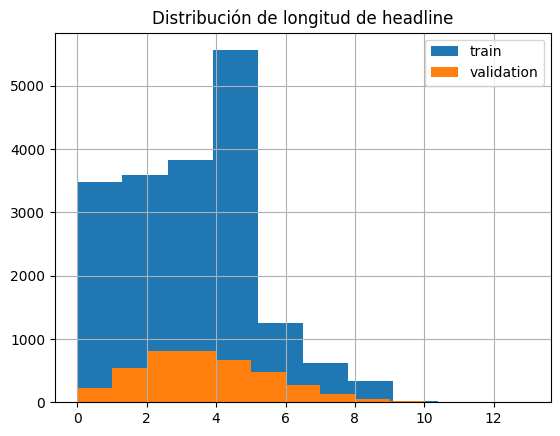

In [18]:
# Visualización de la longitud de las frases
rev_len_train = [len(i) for i in x_train]
rev_len_val = [len(i) for i in x_val]

pd.Series(rev_len_train).hist(label='train')
pd.Series(rev_len_val).hist(label='validation')
plt.legend()
plt.title('Distribución de longitud de headline')
plt.show()


La mayoría de las frases tienen una longitud menor a 15.

Definiremos la función padding para asegurarnos de que todas las secuencias de tokens tengan la misma longitud. Para esto, se rellenarán o truncarán las secuencias según sea necesario.

In [19]:
def padding(sentences, seq_len):

    features = np.zeros((len(sentences), seq_len),dtype=int)
    for index, review in enumerate(sentences):
        if len(review) != 0:
            features[index, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding(x_train,15)
x_val_pad = padding(x_val,15)

Verificamos el código anterior

In [20]:
print(x_train_pad.shape)
print(x_val_pad.shape)

(18696, 15)
(4006, 15)


## 2. Implementar una red neuronal RNN simple con capas lstm

### Tensores

A continuación, crearemos los dataloaders para cargar y manejar datos de entrenamiento y validación en lotes durante el entrenamiento de un modelo.

In [50]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))

# dataloaders
batch_size = 128#50 # 32, 64 o 128 son los valores usualmente empleados

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Training set:')
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

# obtain one batch of training data
dataiter = iter(valid_loader)
sample_x, sample_y = next(dataiter)

print('\n')
print('Validation dataset:')
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Training set:
Sample input size:  torch.Size([128, 15])
Sample input: 
 tensor([[  0,   0,   0,  ..., 289, 575,  66],
        [  0,   0,   0,  ...,   3, 613, 696],
        [  0,   0,   0,  ..., 178, 304, 729],
        ...,
        [  0,   0,   0,  ..., 217, 441,  64],
        [  0,   0,   0,  ...,   1, 977,   1],
        [  0,   0,   0,  ..., 895, 846,  38]])
Sample output: 
 tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1])


Validation dataset:
Sample input size:  torch.Size([128, 15])
Sample input: 
 tensor([[  0,   0,   0,  ...,  14,  25, 445],
        [  0,   0,   0,  ...,   0,   0,  49],
        [  0,   

### Modelo

In [51]:
  class LSTMModel(nn.Module):
    def __init__(self,
                 layers_number, #
                 vocab_size, # Tambien se lo suele escribir como input_size
                 hidden_dim, #
                 embedding_dim, #
                 dropout=0.5):

        super(LSTMModel,self).__init__()

        self.output_dim = output_dim # La cantidad de clases a predecir
        self.hidden_dim = hidden_dim #El numero de nodos en cada capa LSTM (similar a una full conected layer)

        self.layers_number = layers_number # Número de capas LSTM en la red
        self.vocab_size = vocab_size # Tamaño del vocabulario, es decir el número de palabras distintas

        # embedding and LSTM layers
        # Dimension de los vectores de embeddings para representar las palabras
        # Es una matriz que tiene tantas filas como palabras y tantas columnas como la dimension
        # del vector que definimos
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # La capa lstm toma como entrada los embeddings
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=self.hidden_dim, #Representa la cantidad de features en el estado oculto
                           num_layers=layers_number, #Numero de capas recurrentes
                            batch_first=True) #El batch es la primera dimension, nuestros datos tienen la dimension (batch_size, seq_len, features)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.lineal = nn.Linear(self.hidden_dim, output_dim) #Transforma las LSTM en un vector de dimension igual al numero de clases
        self.sigmoid = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0) # Calcula el tamaño del lote dentro de los datos de entrada

        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: BATCH x SENQUENCE_LENGHT x FEATURES   since batch = True (Features es la cantidad total de palabras)
        #print(embeds.shape)  #[X, Y,Z]
        lstm_out, hidden = self.lstm(embeds, hidden) # Obtenemos las celdas de salidas y un nuevo estado oculto

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # Redimensiona para tener la forma (batch_size*seq_len, hidden_dim) -> tensor de 2 dimensiones

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.lineal(out)

        # sigmoid function
        sig_out = self.sigmoid(out)

        #Redimensionamos para tener dimension (batch_size, -1),
        #es decir para obtener las predicciones finales de la red LSTM de cada lote
        sig_out = sig_out.view(batch_size, -1)


        sig_out = sig_out[:, -1] # Selecciona la ultima columna de la variable sig_out que contiene, en general, los resultados de la capa lineal

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.layers_number,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.layers_number,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [52]:
layers_number = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
#Como tenemos un problema de clasificacion binaria y aplicamos la funcion sigmoide
# La salida es un tensor unimensional cuyo valor de activacion nos indica la probabilidad
# de pertenencia a la clase
output_dim = 1
hidden_dim = 256


model = LSTMModel(layers_number,
                  vocab_size,
                  hidden_dim,
                  embedding_dim,
                  dropout=0.5)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')

#moving to gpu
model.to(device)
print(model)

LSTMModel(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (lineal): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [53]:
# loss and optimization functions

lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred,label):
    #Nos aseguramos que tanto pred como label tengan las mismas dimensiones
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item() #Cantidad de predicciones correctas


In [54]:
clip = 5
EPOCHS = 50
valid_loss_min = np.Inf

# train for some number of epochs
epoch_tr_loss = []
epoch_vl_loss = []

epoch_tr_acc = []
epoch_vl_acc = []


#for epoch in trange(EPOCHS):
for epoch in trange(EPOCHS):
  train_losses = []
  train_acc = 0.0
  model.train()

  # initialize hidden state
  # Establecemos el estado inicial en cero
  hidden = model.init_hidden(batch_size)

  # Dado que el dataset tiene x datos y pusimos un batch de y
  # vamos a hacer n pasos de entrenamiento
  for inputs, labels in tqdm(train_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Creamos nuevas variables para el estado oculto,
      # de otra manera propagariamos a lo largo de toda la historia de entrenamiento teniendo problemas del explosion del gradiente.
      # El estado oculto se actualiza en cada paso de tiempo
      # Con la linea siguiente "devinculamos" el estado oculto de cualquier calculo anterior
      # y solo extraemos sus valores copiandolos con each.data
      hidden = tuple([each.data for each in hidden])

      model.zero_grad()
      output,hidden = model(inputs,hidden) #Realizamos un paso hacia adelante

      # Calculamos la loss y hacemos el backpropagation
      loss = criterion(output.squeeze(), labels.float())
      loss.backward()

      train_losses.append(loss.item())

      # calculating accuracy
      accuracy = acc(output,labels)
      train_acc += accuracy

      #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
      # Limita la norma de los gradientes al valor especificado en clip
      # model.parameters() es una lista de los parámetros del modelo,
      # que son tensores en los que se almacenan los gradientes después de realizar la retropropagación del error.
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step()

  val_h = model.init_hidden(batch_size)
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:
          val_h = tuple([each.data for each in val_h])

          inputs =  inputs.to(device)
          labels = labels.to(device)


          output, val_h = model(inputs, val_h)
          val_loss = criterion(output.squeeze(), labels.float())


          val_losses.append(val_loss.item())

          accuracy = acc(output,labels)
          val_acc += accuracy

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)

  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)

  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)

  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)

  print(f'Epoch {epoch+1}')
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

  if epoch_val_loss <= valid_loss_min:
      torch.save(model.state_dict(), 'state_dict.pt')
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
      valid_loss_min = epoch_val_loss
  print(25*'==')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.6415021815528609 val_loss : 0.5988657397608603
train_accuracy : 62.08814719726144 val_accuracy : 66.20069895157265
Validation loss decreased (inf --> 0.598866).  Saving model ...


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.5538596949756962 val_loss : 0.5420771106596916
train_accuracy : 70.56054771074027 val_accuracy : 70.54418372441337
Validation loss decreased (0.598866 --> 0.542077).  Saving model ...


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 3
train_loss : 0.49660959247856923 val_loss : 0.5230543632661143
train_accuracy : 74.97325631151048 val_accuracy : 72.34148776834748
Validation loss decreased (0.542077 --> 0.523054).  Saving model ...


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 4
train_loss : 0.4553149583405011 val_loss : 0.5305175656272519
train_accuracy : 77.46041934103552 val_accuracy : 72.14178731902146


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 5
train_loss : 0.4162304852515051 val_loss : 0.5561247333403556
train_accuracy : 79.81921266581087 val_accuracy : 71.59261108337493


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 6
train_loss : 0.3748913750256578 val_loss : 0.5990012365002786
train_accuracy : 81.8303380402225 val_accuracy : 71.76734897653519


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 7
train_loss : 0.32899039534673297 val_loss : 0.6751987126565748
train_accuracy : 84.30680359435173 val_accuracy : 71.41787319021468


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 8
train_loss : 0.2741028438896349 val_loss : 0.7801624632650807
train_accuracy : 86.81001283697047 val_accuracy : 70.14478282576135


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 9
train_loss : 0.23253952926152374 val_loss : 0.8918743652682151
train_accuracy : 88.7890457851947 val_accuracy : 70.84373439840239


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 10
train_loss : 0.19551077633075517 val_loss : 1.053405059922126
train_accuracy : 90.4257595207531 val_accuracy : 69.79530703944083


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 11
train_loss : 0.16974595280951016 val_loss : 1.2135773474170315
train_accuracy : 91.77899015832264 val_accuracy : 68.99650524213679


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 12
train_loss : 0.1501223579661487 val_loss : 1.3532909193346578
train_accuracy : 92.50106974753957 val_accuracy : 70.09485771342986


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 13
train_loss : 0.13465481404572316 val_loss : 1.5927021407311963
train_accuracy : 93.22314933675653 val_accuracy : 70.34448327508737


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 14
train_loss : 0.12562023156820096 val_loss : 1.73873770236969
train_accuracy : 93.61895592640137 val_accuracy : 69.89515726410384


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 15
train_loss : 0.12091410836230403 val_loss : 1.7808553826424383
train_accuracy : 93.79011553273428 val_accuracy : 69.94508237643535


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 16
train_loss : 0.1149957237433489 val_loss : 2.019380488703328
train_accuracy : 93.97197261446298 val_accuracy : 70.24463305042437


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 17
train_loss : 0.11219109645853304 val_loss : 1.9647202337941816
train_accuracy : 94.21266581086863 val_accuracy : 69.42086869695456


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 18
train_loss : 0.11263594949898655 val_loss : 2.2874761935203307
train_accuracy : 94.03615746683782 val_accuracy : 70.76884672990515


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 19
train_loss : 0.11353698508074023 val_loss : 1.9993137621110486
train_accuracy : 94.11638853230637 val_accuracy : 69.2461308037943


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 20
train_loss : 0.11933754063020013 val_loss : 2.064812021870767
train_accuracy : 94.21801454856654 val_accuracy : 69.59560659011483


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 21
train_loss : 0.11121583382969033 val_loss : 2.029361932508407
train_accuracy : 94.16452717158751 val_accuracy : 70.0199700449326


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 22
train_loss : 0.10174995872562062 val_loss : 2.710321964756135
train_accuracy : 94.51219512195121 val_accuracy : 70.0199700449326


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 23
train_loss : 0.10137014422718793 val_loss : 2.389043092727661
train_accuracy : 94.52824133504492 val_accuracy : 69.37094358462306


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 24
train_loss : 0.10701274078288307 val_loss : 2.3072004087509645
train_accuracy : 94.24475823705606 val_accuracy : 70.1697453819271


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 25
train_loss : 0.10699311470332211 val_loss : 2.1183579006502704
train_accuracy : 94.33568677792042 val_accuracy : 69.72041937094359


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 26
train_loss : 0.10132562491583498 val_loss : 2.4552015758329824
train_accuracy : 94.37312794180573 val_accuracy : 69.94508237643535


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 27
train_loss : 0.10406475401904484 val_loss : 2.192647895505351
train_accuracy : 94.41056910569105 val_accuracy : 70.64403394907639


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 28
train_loss : 0.10143907480452159 val_loss : 2.2095007319604196
train_accuracy : 94.53359007274284 val_accuracy : 69.52071892161757


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 29
train_loss : 0.0969035581825939 val_loss : 2.685842425592484
train_accuracy : 94.60847240051348 val_accuracy : 70.1198202695956


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 30
train_loss : 0.0955471780712474 val_loss : 2.747705847986283
train_accuracy : 94.58172871202396 val_accuracy : 69.94508237643535


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 31
train_loss : 0.09453154413973631 val_loss : 2.912421276492457
train_accuracy : 94.65661103979461 val_accuracy : 70.41937094358462


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 32
train_loss : 0.09392540588056388 val_loss : 3.185832642739819
train_accuracy : 94.58707744972187 val_accuracy : 70.26959560659012


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 33
train_loss : 0.09332815774601616 val_loss : 3.264548847752233
train_accuracy : 94.67265725288831 val_accuracy : 69.94508237643535


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 34
train_loss : 0.09349660220721813 val_loss : 3.4283519329563266
train_accuracy : 94.6459135643988 val_accuracy : 69.74538192710934


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 35
train_loss : 0.09283523667246511 val_loss : 3.397579373851899
train_accuracy : 94.69940094137783 val_accuracy : 69.64553170244633


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 36
train_loss : 0.09230600866450839 val_loss : 3.545532657254127
train_accuracy : 94.74219084296107 val_accuracy : 70.59410883674488


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 37
train_loss : 0.0939039679703443 val_loss : 3.4841309555115236
train_accuracy : 94.6298673513051 val_accuracy : 69.52071892161757


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 38
train_loss : 0.12692944787136495 val_loss : 1.6033110695500528
train_accuracy : 93.79546427043218 val_accuracy : 69.32101847229156


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 39
train_loss : 0.12035259910642285 val_loss : 1.6438678560718414
train_accuracy : 93.8275566966196 val_accuracy : 69.0464303544683


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 40
train_loss : 0.1004634285473252 val_loss : 1.953881279114754
train_accuracy : 94.50684638425332 val_accuracy : 69.47079380928606


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 41
train_loss : 0.09313005783072073 val_loss : 2.2613441790303876
train_accuracy : 94.76358579375267 val_accuracy : 69.9700449326011


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 42
train_loss : 0.09220647332194733 val_loss : 2.514313793951465
train_accuracy : 94.72614462986735 val_accuracy : 70.21967049425861


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 43
train_loss : 0.09164305038954297 val_loss : 2.599203298168798
train_accuracy : 94.65126230209671 val_accuracy : 70.44433349975037


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 44
train_loss : 0.09125432581321834 val_loss : 2.72298074922254
train_accuracy : 94.69405220367993 val_accuracy : 70.44433349975037


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 45
train_loss : 0.09070155899716567 val_loss : 2.8769973631828063
train_accuracy : 94.71544715447155 val_accuracy : 70.54418372441337


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 46
train_loss : 0.09073642429525722 val_loss : 2.974966945186738
train_accuracy : 94.73684210526315 val_accuracy : 70.61907139291064


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 47
train_loss : 0.09062570404924758 val_loss : 2.9689122707613054
train_accuracy : 94.75823705605477 val_accuracy : 70.51922116824763


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 48
train_loss : 0.09055212599365678 val_loss : 3.099185812857843
train_accuracy : 94.68335472828413 val_accuracy : 71.01847229156265


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 49
train_loss : 0.09028622893335884 val_loss : 3.1247397699663715
train_accuracy : 94.69940094137783 val_accuracy : 70.24463305042437


  0%|          | 0/146 [00:00<?, ?it/s]

Epoch 50
train_loss : 0.09021267455632556 val_loss : 3.399687809328879
train_accuracy : 94.8063756953359 val_accuracy : 70.56914628057913


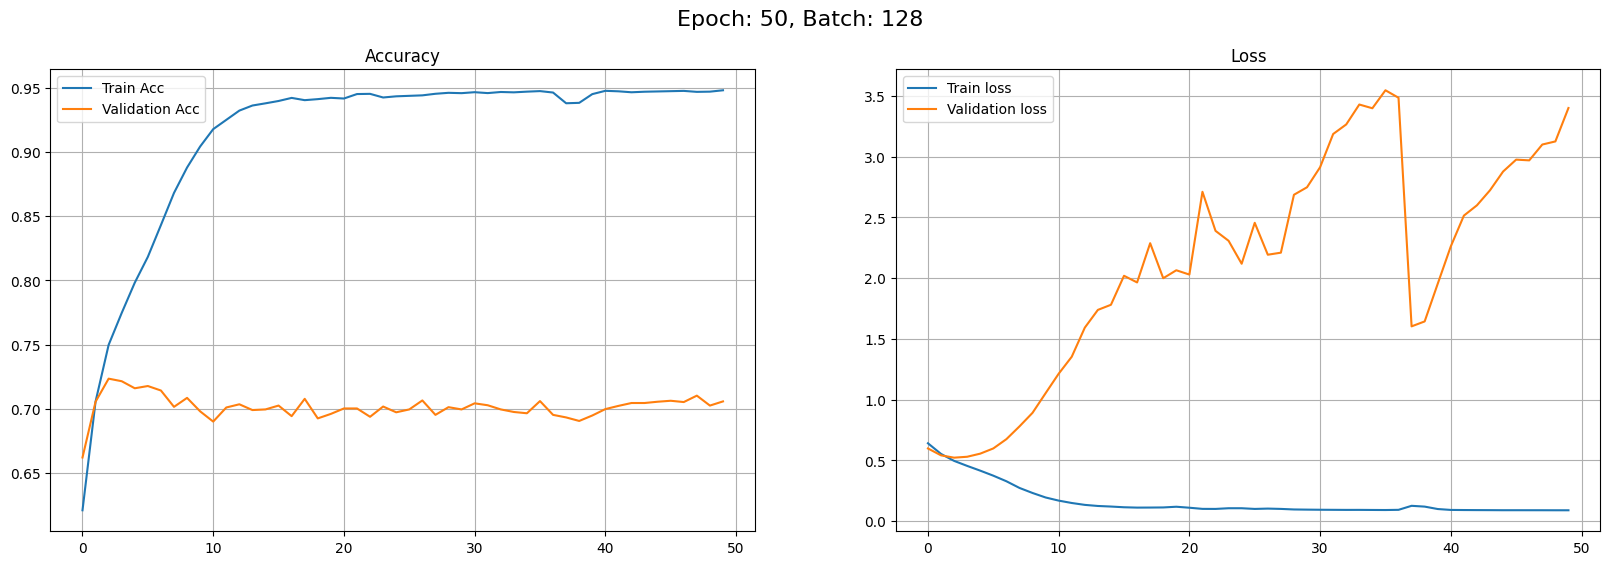

In [56]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()
plt.suptitle('Epoch: 50, Batch: 128', fontsize=16)

plt.show()


## 3. Búsqueda de hiperparametros buscando mejorar el baseline. Traten de centrarse en probar 2, como mucho 3, hiperparametros y ver los cambios en base a esos hiperparametros porque sino las pruebas se hacen infinitas. La idea es que prueben:

  * Diferentes tamaños de épocas,
  * Tamaño de batch,
  * Cantidad de capas lstm,
  * Valor de dropout, etc.


## 4. Mostrar e Interpretar los resultados usando las curvas de aprendizaje.

Epoch: 50
Batch: 32

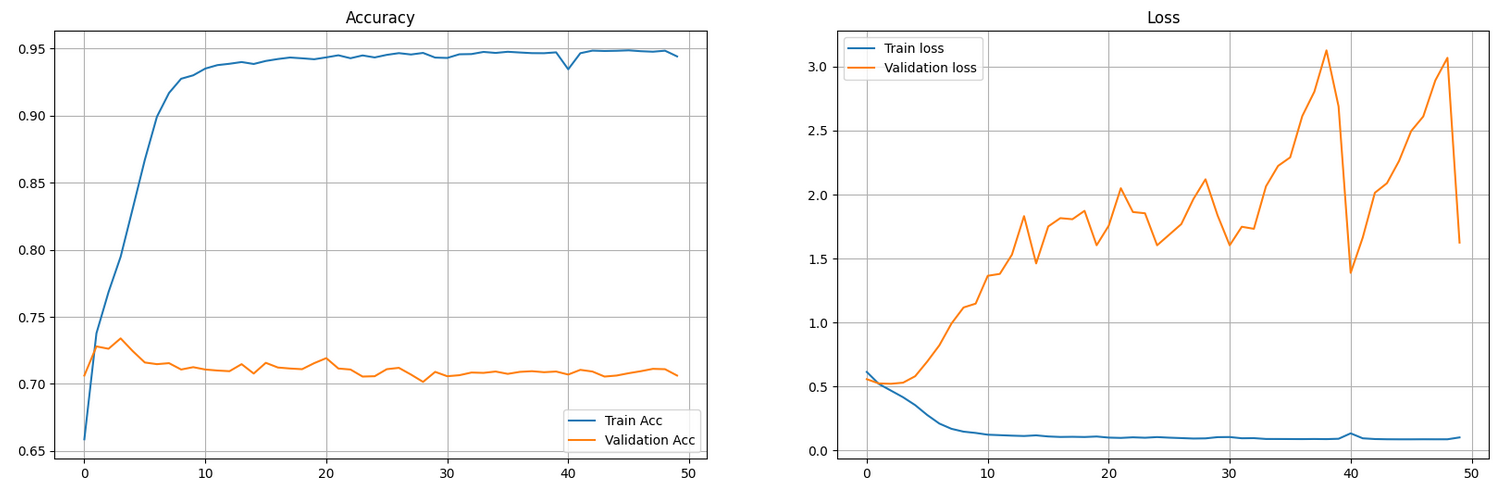

Epoch:50 Batch: 50

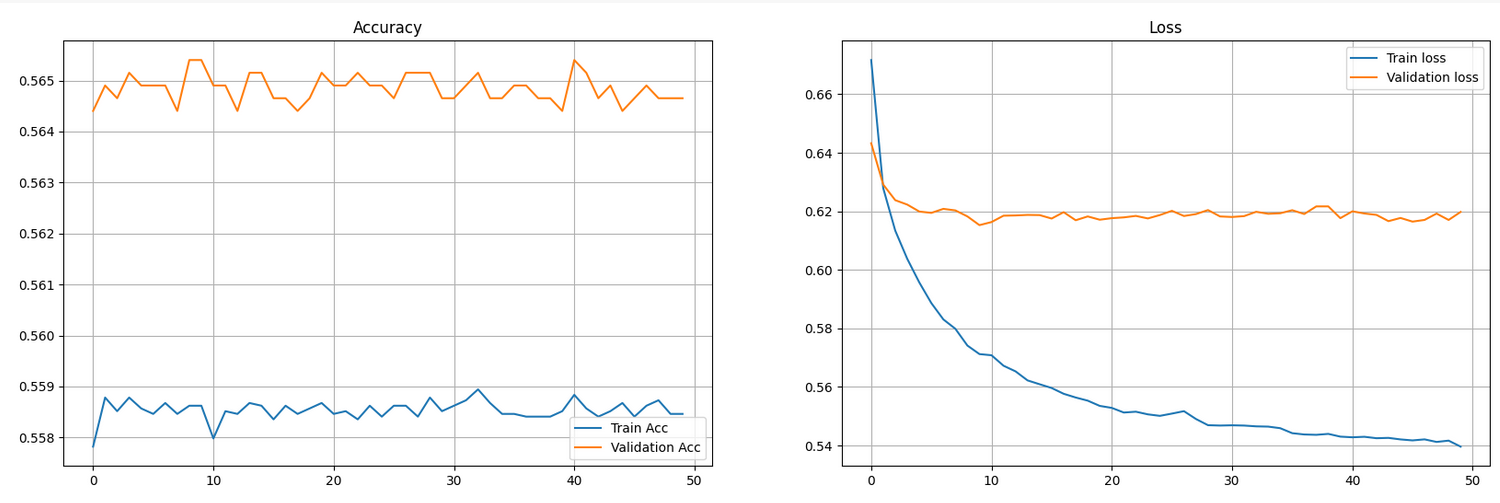

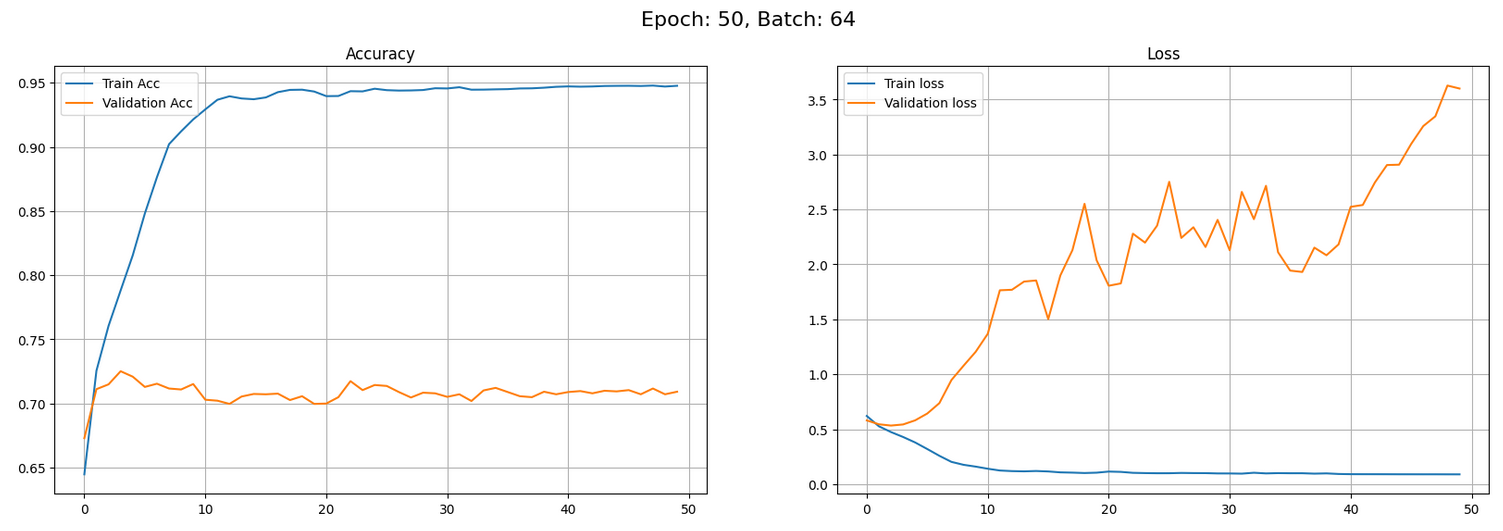

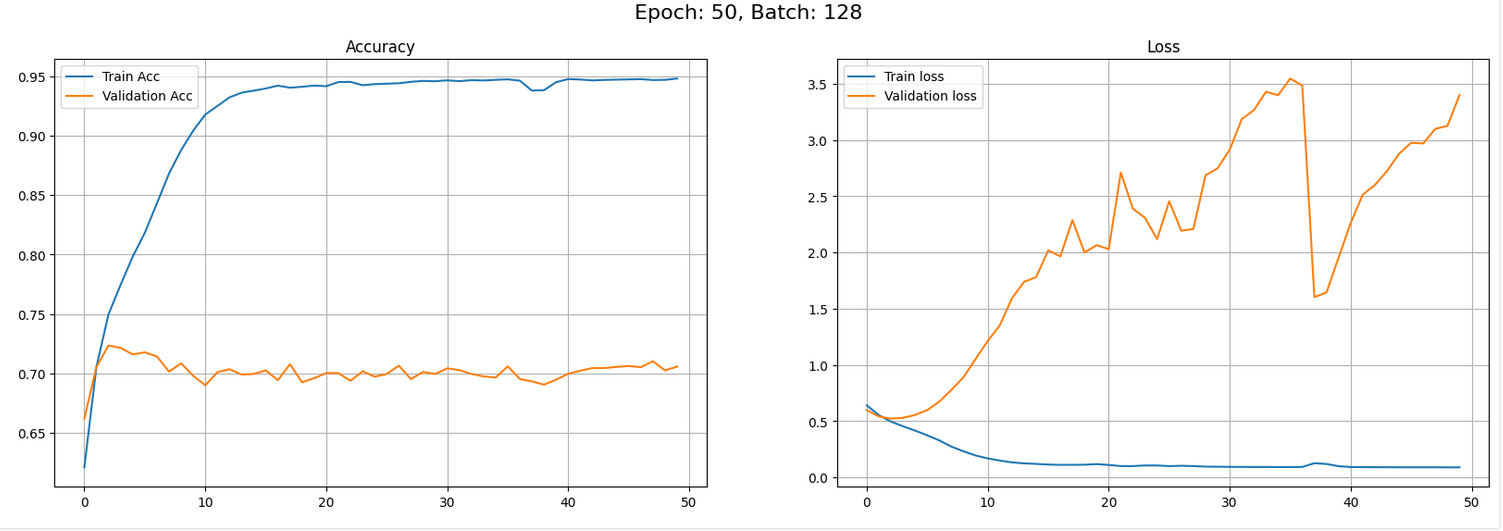